In [11]:
import os
import time

import timm
import torch
import albumentations as A
import pandas as pd
import numpy as np
import torch.nn as nn

from albumentations.pytorch import ToTensorV2
from torch.optim import Adam
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from torchvision.datasets import ImageFolder
from torch.optim.lr_scheduler import CosineAnnealingLR

from PIL import Image
from tqdm import tqdm
from sklearn.metrics import accuracy_score, f1_score

import wandb

In [12]:
class ImageDataset(Dataset):
    def __init__(self, csv, path, transform=None):
        self.df = pd.read_csv(csv).values
        self.path = path
        self.transform = transform

    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        name, target = self.df[idx]
        img = np.array(Image.open(os.path.join(self.path, name)))
        if self.transform:
            img = self.transform(image = img)['image']
    
        return img, target

    def get_labels(self):
        return self.df[:, 1] 

In [24]:
# one epoch 학습
def train_one_epoch(loader, model, optimizer, loss_fn, device, epoch):
    model.train()
    train_loss = 0
    preds_list =[]
    targets_list = []

    pbar = tqdm(loader)
    for step, (image, targets) in enumerate(pbar):
        image = image.to(device)
        targets = targets.to(device)

        model.zero_grad(set_to_none = True)

        preds = model(image)
        loss = loss_fn(preds, targets)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        
        preds_list.extend(preds.argmax(dim=1).detach().cpu().numpy())
        targets_list.extend(targets.detach().cpu().numpy())

        pbar.set_description(f"Loss: {loss.item():.4f}")

        wandb.log({
            "train_step" : epoch * len(loader) + step,
            "train_loss_step" : loss.item()
        })

    train_loss /= len(loader)
    train_acc = accuracy_score(targets_list, preds_list)
    train_f1 = f1_score(targets_list, preds_list, average = 'macro')

    ret = {
        "model" : model,
        "train_epoch" : epoch,
        "train_loss" : train_loss,
        "tarin_acc" : train_acc,
        "train_f1" : train_f1
    }


    wandb.log({
        "train_epoch" : epoch,
        "train_loss_epoch" : train_loss,
        "train_acc" : train_acc,
        "train_f1" : train_f1
    })

    return ret

In [25]:
def valid_one_epoch(loader, model, loss_fn, device, epoch):
    model.eval()
    valid_loss = 0

    preds_list =[]
    targets_list = []

    with torch.no_grad():
        pbar = tqdm(loader)
        for step, (image, targets) in enumerate(pbar):
            image = image.to(device)
            targets = targets.to(device)

            preds = model(image)
            loss = loss_fn(preds, targets)
       
            valid_loss += loss.item()
        
            preds_list.extend(preds.argmax(dim=1).detach().cpu().numpy())
            targets_list.extend(targets.detach().cpu().numpy())

            pbar.set_description(f"Loss: {loss.item():.4f}")

            wandb.log({
                "valid_step" : epoch * len(loader) + step,
                "valid_loss_step" : loss.item()
            })

    valid_loss /= len(loader)
    valid_acc = accuracy_score(targets_list, preds_list)
    valid_f1 = f1_score(targets_list, preds_list, average = 'macro')

    ret = {
        "model" : model,
        "epoch" : epoch,
        "valid_loss" : valid_loss,
        "valid_acc" : valid_acc,
        "valid_f1" : valid_f1
    }

    wandb.log({
        "valid_epoch" : epoch,
        "val_loss_epoch" : valid_loss,
        "val_acc" : valid_acc,
        "val_f1" : valid_f1
    })

    return ret

# Hyper parameters

In [15]:
# device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# data config
data_path = 'data/'

# model config
model_name = 'resnet50'

# training config
img_size = 224
LR = 1e-3
EPOCHS = 3
BATCH_SIZE = 32
num_workers = 0


# Load Data

In [16]:
# train image 변환
trn_transform = A.Compose([
    A.Resize(height = img_size, width = img_size),
    A.Normalize(mean = [0.485, 0.486, 0.406], std = [0.229, 0.224, 0.225]),
    ToTensorV2(),
])

# test image 변환
tst_transform = A.Compose([
    A.Resize(height = img_size, width = img_size),
    A.Normalize(mean=[0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225]),
    ToTensorV2()
])

In [17]:
trn_dataset = ImageDataset(
    "/upstage-cv-classification-cv2/data/train.csv",
    "/upstage-cv-classification-cv2/data/train",
    transform = trn_transform
)

tst_dataset = ImageDataset(
    "/upstage-cv-classification-cv2/data/sample_submission.csv",
    "/upstage-cv-classification-cv2/data/test",
    transform = tst_transform
)

print(len(trn_dataset), len(tst_dataset))

1570 3140


In [18]:
labels = trn_dataset.get_labels()
print(f"Original labels type: {type(labels[0])}, dtype: {labels.dtype}")
labels = labels.astype(int)
print(f"Original labels type: {type(labels[0])}, dtype: {labels.dtype}")


Original labels type: <class 'int'>, dtype: object
Original labels type: <class 'numpy.int64'>, dtype: int64


# Train Model

In [28]:
models = {
    # ResNet50
    'resnet50' : timm.create_model('resnet50',
                                pretrained=True,
                                num_classes = 17).to(device),
    # ResNeXt50
    'resnext50' : timm.create_model('resnext50_32x4d', 
                                pretrained=True,
                                num_classes = 17).to(device),
    # EfficientNet-B0
    'efficientnet_b0' : timm.create_model('efficientnet_b0',
                                    pretrained=True,
                                    num_classes = 17).to(device),
    # EfficientNet-B4
    'efficientnet_b4' : timm.create_model('efficientnet_b4',
                                    pretrained=True,
                                    num_classes = 17).to(device),
    # CAFormer-S18
    'caformer_s18' : timm.create_model('caformer_s18',
                                    pretrained=True,
                                    num_classes = 17).to(device),
    # ViT LAION 2B
    'vit_laion_2b' : timm.create_model('vit_large_patch14_clip_224.laion2b',
                                    pretrained=True,
                                    num_classes = 17).to(device)

}

INFO:timm.models._builder:Loading pretrained weights from Hugging Face hub (timm/resnet50.a1_in1k)
INFO:timm.models._hub:[timm/resnet50.a1_in1k] Safe alternative available for 'pytorch_model.bin' (as 'model.safetensors'). Loading weights using safetensors.
INFO:timm.models._builder:Missing keys (fc.weight, fc.bias) discovered while loading pretrained weights. This is expected if model is being adapted.
INFO:timm.models._builder:Loading pretrained weights from Hugging Face hub (timm/resnext50_32x4d.a1h_in1k)
INFO:timm.models._hub:[timm/resnext50_32x4d.a1h_in1k] Safe alternative available for 'pytorch_model.bin' (as 'model.safetensors'). Loading weights using safetensors.
INFO:timm.models._builder:Missing keys (fc.weight, fc.bias) discovered while loading pretrained weights. This is expected if model is being adapted.
INFO:timm.models._builder:Loading pretrained weights from Hugging Face hub (timm/efficientnet_b0.ra_in1k)
INFO:timm.models._hub:[timm/efficientnet_b0.ra_in1k] Safe alternat

In [29]:
from sklearn.model_selection import StratifiedKFold
from torch.utils.data import Subset
import os

os.environ['WANDB_SILENT'] = 'true'
skf = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 42)

best_models = {}

for model_name, model in models.items():
    print("-" * 100)
    print(model_name)

    f1_scores = []
    valid_losses = []
    trained_models = []

    loss_fn = nn.CrossEntropyLoss()
    optimizer = Adam(model.parameters(), lr = LR)

    wandb.init(project="cv_competition_base_models_4", name=f"{model_name}", reinit=True)
    
    for fold, (train_idx, val_idx) in enumerate(skf.split(trn_dataset, labels)):
        print(f'fold : {fold}')
        train_dataset = Subset(trn_dataset, train_idx)
        val_dataset = Subset(trn_dataset, val_idx)

        trn_loader = DataLoader(
            train_dataset,
            batch_size = BATCH_SIZE,
            shuffle = True,
            num_workers = num_workers,
            pin_memory = True,
            drop_last = False
        )

        val_loader = DataLoader(
            val_dataset,
            batch_size = BATCH_SIZE,
            shuffle = False,
            num_workers = 0,
            pin_memory = True
        )

        for epoch in range(EPOCHS):
            print(f"\tepoch : {epoch}")
            trn_ret = train_one_epoch(trn_loader, model, optimizer, loss_fn, device, epoch)
            val_ret =  valid_one_epoch(val_loader, model, loss_fn, device, epoch)

            f1_scores.append(val_ret['valid_f1'])
            valid_losses.append(val_ret['valid_loss'])
            trained_models.append(val_ret['model'])
    
    best_model_idx = np.argmax(np.array(f1_scores))
    best_models[model_name] = trained_models[best_model_idx]
    
wandb.finish()

----------------------------------------------------------------------------------------------------
resnet50


fold : 0
	epoch : 0


Loss: 0.7329: 100%|██████████| 10/10 [00:00<00:00, 11.96it/s]


	epoch : 1


Loss: 0.3169: 100%|██████████| 10/10 [00:00<00:00, 12.00it/s]


	epoch : 2


Loss: 0.2901: 100%|██████████| 10/10 [00:00<00:00, 12.02it/s]


fold : 1
	epoch : 0


Loss: 0.0711: 100%|██████████| 10/10 [00:00<00:00, 11.89it/s]


	epoch : 1


Loss: 0.0424: 100%|██████████| 10/10 [00:00<00:00, 12.14it/s]


	epoch : 2


Loss: 0.1275: 100%|██████████| 10/10 [00:00<00:00, 12.04it/s]


fold : 2
	epoch : 0


Loss: 0.0548: 100%|██████████| 10/10 [00:00<00:00, 11.91it/s]


	epoch : 1


Loss: 0.0284: 100%|██████████| 10/10 [00:00<00:00, 11.82it/s]


	epoch : 2


Loss: 0.0077: 100%|██████████| 10/10 [00:00<00:00, 11.95it/s]


fold : 3
	epoch : 0


Loss: 0.0020: 100%|██████████| 10/10 [00:00<00:00, 11.98it/s]


	epoch : 1


Loss: 0.0031: 100%|██████████| 10/10 [00:00<00:00, 12.07it/s]


	epoch : 2


Loss: 0.0017: 100%|██████████| 10/10 [00:00<00:00, 11.89it/s]


fold : 4
	epoch : 0


Loss: 0.0018: 100%|██████████| 10/10 [00:00<00:00, 12.18it/s]


	epoch : 1


Loss: 0.0035: 100%|██████████| 10/10 [00:00<00:00, 11.74it/s]


	epoch : 2


Loss: 0.0026: 100%|██████████| 10/10 [00:00<00:00, 12.17it/s]


----------------------------------------------------------------------------------------------------
resnext50


fold : 0
	epoch : 0


Loss: 0.6987: 100%|██████████| 10/10 [00:00<00:00, 11.25it/s]


	epoch : 1


Loss: 0.3296: 100%|██████████| 10/10 [00:00<00:00, 11.13it/s]


	epoch : 2


Loss: 0.2233: 100%|██████████| 10/10 [00:00<00:00, 11.26it/s]


fold : 1
	epoch : 0


Loss: 0.0426: 100%|██████████| 10/10 [00:00<00:00, 11.10it/s]


	epoch : 1


Loss: 0.1002: 100%|██████████| 10/10 [00:00<00:00, 11.33it/s]


	epoch : 2


Loss: 0.1219: 100%|██████████| 10/10 [00:00<00:00, 10.92it/s]


fold : 2
	epoch : 0


Loss: 0.0205: 100%|██████████| 10/10 [00:00<00:00, 11.19it/s]


	epoch : 1


Loss: 0.1228: 100%|██████████| 10/10 [00:00<00:00, 11.31it/s]


	epoch : 2


Loss: 0.2691: 100%|██████████| 10/10 [00:00<00:00, 11.12it/s]


fold : 3
	epoch : 0


Loss: 0.0242: 100%|██████████| 10/10 [00:00<00:00, 11.05it/s]


	epoch : 1


Loss: 0.0265: 100%|██████████| 10/10 [00:00<00:00, 11.03it/s]


	epoch : 2


Loss: 0.0363: 100%|██████████| 10/10 [00:00<00:00, 11.07it/s]


fold : 4
	epoch : 0


Loss: 0.0117: 100%|██████████| 10/10 [00:00<00:00, 11.16it/s]


	epoch : 1


Loss: 0.0053: 100%|██████████| 10/10 [00:00<00:00, 11.42it/s]


	epoch : 2


Loss: 0.0448: 100%|██████████| 10/10 [00:00<00:00, 11.14it/s]


----------------------------------------------------------------------------------------------------
efficientnet_b0


fold : 0
	epoch : 0


Loss: 0.3169: 100%|██████████| 10/10 [00:00<00:00, 14.32it/s]


	epoch : 1


Loss: 0.6263: 100%|██████████| 10/10 [00:00<00:00, 14.23it/s]


	epoch : 2


Loss: 0.4664: 100%|██████████| 10/10 [00:00<00:00, 13.46it/s]


fold : 1
	epoch : 0


Loss: 0.0256: 100%|██████████| 10/10 [00:00<00:00, 13.60it/s]


	epoch : 1


Loss: 0.1280: 100%|██████████| 10/10 [00:00<00:00, 14.26it/s]


	epoch : 2


Loss: 0.0418: 100%|██████████| 10/10 [00:00<00:00, 14.60it/s]


fold : 2
	epoch : 0


Loss: 0.2881: 100%|██████████| 10/10 [00:00<00:00, 13.95it/s]


	epoch : 1


Loss: 0.0226: 100%|██████████| 10/10 [00:00<00:00, 14.28it/s]


	epoch : 2


Loss: 0.0152: 100%|██████████| 10/10 [00:00<00:00, 14.54it/s]


fold : 3
	epoch : 0


Loss: 0.0861: 100%|██████████| 10/10 [00:00<00:00, 14.30it/s]


	epoch : 1


Loss: 0.0108: 100%|██████████| 10/10 [00:00<00:00, 14.47it/s]


	epoch : 2


Loss: 0.3318: 100%|██████████| 10/10 [00:00<00:00, 14.44it/s]


fold : 4
	epoch : 0


Loss: 0.3355: 100%|██████████| 10/10 [00:00<00:00, 13.64it/s]


	epoch : 1


Loss: 0.0204: 100%|██████████| 10/10 [00:00<00:00, 13.65it/s]


	epoch : 2


Loss: 0.0241: 100%|██████████| 10/10 [00:00<00:00, 14.03it/s]


----------------------------------------------------------------------------------------------------
efficientnet_b4


fold : 0
	epoch : 0


Loss: 0.4316: 100%|██████████| 10/10 [00:00<00:00, 11.28it/s]


	epoch : 1


Loss: 0.3848: 100%|██████████| 10/10 [00:00<00:00, 11.74it/s]


	epoch : 2


Loss: 0.4135: 100%|██████████| 10/10 [00:00<00:00, 10.59it/s]


fold : 1
	epoch : 0


Loss: 0.0558: 100%|██████████| 10/10 [00:00<00:00, 11.04it/s]


	epoch : 1


Loss: 0.0196: 100%|██████████| 10/10 [00:00<00:00, 11.45it/s]


	epoch : 2


Loss: 0.0056: 100%|██████████| 10/10 [00:00<00:00, 11.02it/s]


fold : 2
	epoch : 0


Loss: 0.0001: 100%|██████████| 10/10 [00:00<00:00, 11.08it/s]


	epoch : 1


Loss: 0.0000: 100%|██████████| 10/10 [00:00<00:00, 11.09it/s]


	epoch : 2


Loss: 0.0000: 100%|██████████| 10/10 [00:00<00:00, 11.64it/s]


fold : 3
	epoch : 0


Loss: 0.0001: 100%|██████████| 10/10 [00:00<00:00, 11.60it/s]


	epoch : 1


Loss: 0.0016: 100%|██████████| 10/10 [00:00<00:00, 11.78it/s]


	epoch : 2


Loss: 0.0002: 100%|██████████| 10/10 [00:00<00:00, 11.35it/s]


fold : 4
	epoch : 0


Loss: 0.0000: 100%|██████████| 10/10 [00:00<00:00, 11.37it/s]


	epoch : 1


Loss: 0.0000: 100%|██████████| 10/10 [00:00<00:00, 11.01it/s]


	epoch : 2


Loss: 0.0001: 100%|██████████| 10/10 [00:00<00:00, 11.74it/s]


----------------------------------------------------------------------------------------------------
caformer_s18


fold : 0
	epoch : 0


Loss: 1.1165: 100%|██████████| 10/10 [00:00<00:00, 10.14it/s]


	epoch : 1


Loss: 0.5070: 100%|██████████| 10/10 [00:00<00:00, 10.15it/s]


	epoch : 2


Loss: 0.9123: 100%|██████████| 10/10 [00:00<00:00, 10.59it/s]


fold : 1
	epoch : 0


Loss: 0.2116: 100%|██████████| 10/10 [00:00<00:00, 10.70it/s]


	epoch : 1


Loss: 0.2968: 100%|██████████| 10/10 [00:00<00:00, 10.47it/s]


	epoch : 2


Loss: 0.2930: 100%|██████████| 10/10 [00:00<00:00, 10.52it/s]


fold : 2
	epoch : 0


Loss: 0.1258: 100%|██████████| 10/10 [00:00<00:00, 10.40it/s]


	epoch : 1


Loss: 0.2561: 100%|██████████| 10/10 [00:00<00:00, 10.68it/s]


	epoch : 2


Loss: 0.1303: 100%|██████████| 10/10 [00:00<00:00, 10.21it/s]


fold : 3
	epoch : 0


Loss: 0.0764: 100%|██████████| 10/10 [00:00<00:00, 10.27it/s]


	epoch : 1


Loss: 0.0488: 100%|██████████| 10/10 [00:00<00:00, 10.75it/s]


	epoch : 2


Loss: 0.2261: 100%|██████████| 10/10 [00:00<00:00, 10.43it/s]


fold : 4
	epoch : 0


Loss: 0.2250: 100%|██████████| 10/10 [00:00<00:00, 10.21it/s]


	epoch : 1


Loss: 0.6543: 100%|██████████| 10/10 [00:00<00:00, 10.62it/s]


	epoch : 2


Loss: 0.1442: 100%|██████████| 10/10 [00:00<00:00, 10.11it/s]


----------------------------------------------------------------------------------------------------
vit_laion_2b


fold : 0
	epoch : 0


Loss: 2.9595: 100%|██████████| 10/10 [00:03<00:00,  2.62it/s]


	epoch : 1


Loss: 2.3883: 100%|██████████| 10/10 [00:04<00:00,  2.44it/s]


	epoch : 2


Loss: 2.3230: 100%|██████████| 10/10 [00:04<00:00,  2.44it/s]


fold : 1
	epoch : 0


Loss: 1.9627: 100%|██████████| 10/10 [00:04<00:00,  2.39it/s]


	epoch : 1


Loss: 2.0501: 100%|██████████| 10/10 [00:04<00:00,  2.40it/s]


	epoch : 2


Loss: 2.7789: 100%|██████████| 10/10 [00:04<00:00,  2.35it/s]


fold : 2
	epoch : 0


Loss: 2.3745: 100%|██████████| 10/10 [00:04<00:00,  2.47it/s]


	epoch : 1


Loss: 2.1551: 100%|██████████| 10/10 [00:04<00:00,  2.47it/s]


	epoch : 2


Loss: 2.3196: 100%|██████████| 10/10 [00:04<00:00,  2.40it/s]


fold : 3
	epoch : 0


Loss: 1.8297: 100%|██████████| 10/10 [00:04<00:00,  2.42it/s]


	epoch : 1


Loss: 1.7862: 100%|██████████| 10/10 [00:04<00:00,  2.46it/s]


	epoch : 2


Loss: 1.7685: 100%|██████████| 10/10 [00:04<00:00,  2.38it/s]


fold : 4
	epoch : 0


Loss: 1.5149: 100%|██████████| 10/10 [00:04<00:00,  2.48it/s]


	epoch : 1


Loss: 1.5073: 100%|██████████| 10/10 [00:04<00:00,  2.44it/s]


	epoch : 2


Loss: 1.6205: 100%|██████████| 10/10 [00:04<00:00,  2.45it/s]


# Test

In [31]:
tst_loader = DataLoader(
    tst_dataset,
    batch_size = BATCH_SIZE,
    shuffle = False,
    num_workers = 0,
    pin_memory = True
)

In [34]:
for model_name, model in best_models.items():
    preds_list = []
    model.eval()

    for image, _ in tqdm(tst_loader):
        image = image.to(device)

        with torch.no_grad():
            preds = model(image)
        preds_list.extend(preds.argmax(dim=1).detach().cpu().numpy())

    pred_df = pd.DataFrame(tst_dataset.df, columns=['ID', 'target'])
    pred_df['target'] = preds_list
    pred_df.to_csv(f"/upstage-cv-classification-cv2/{model_name}_pred.csv", index=False)

100%|██████████| 99/99 [00:37<00:00,  2.66it/s]


# Result Analyze

In [33]:
trn_loader = DataLoader(
    trn_dataset,
    batch_size = BATCH_SIZE,
    shuffle = True,
    num_workers = num_workers,
    pin_memory = True,
    drop_last = False
)

100%|██████████| 50/50 [00:18<00:00,  2.69it/s]


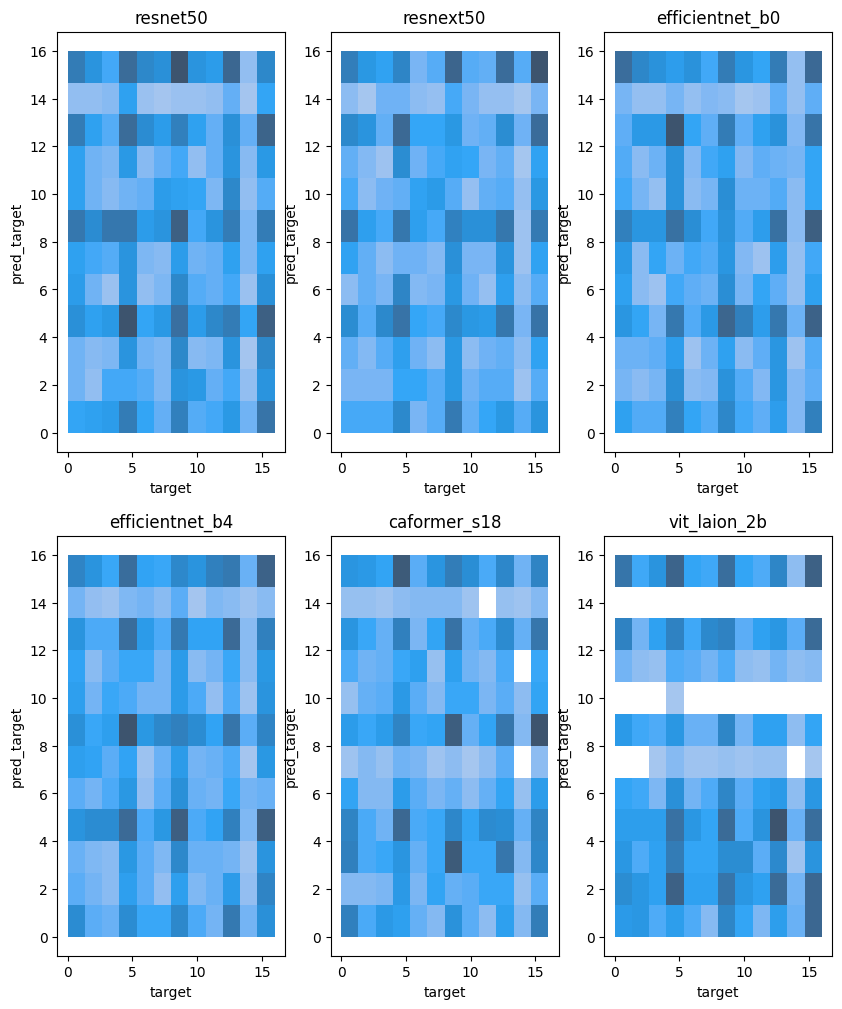

In [36]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 12))

for idx, (model_name, model) in enumerate(best_models.items()):
    preds_list = []
    model.eval()

    for image, _ in tqdm(trn_loader):
        image = image.to(device)

        with torch.no_grad():
            preds = model(image)
        preds_list.extend(preds.argmax(dim=1).detach().cpu().numpy())

    pred_df = pd.DataFrame(trn_dataset.df, columns=['ID', 'target'])
    pred_df['pred_target'] = preds_list

    plt.subplot(2, 3, idx+1)
    plt.title(model_name)
    sns.histplot(data=pred_df, x = "target", y='pred_target', bins=range(11), cbar=True)


In [37]:
SWIN
efficient_b4
clip

NameError: name 'CLIP' is not defined